# Laboratory of Computational Physics mod. B at Phisics of Data, University of Padova

__Authors:__

- Valeria Fioroni (University of Padova)
- Matteo Guida (University of Padova)
- Philipp Zehetner (University of Padova, Ludwig Maximilian University of Munich)

__Supervised by:__

- Professor Marco Zanetti (University of Padova, CERN)
- Professor Stefano Lacaprara (University of Padova, BELLE2)

## 1. The Signal

At the SuperKEKB paricle accelerator electrons and positrons collide with a center-of-momentum energy clos to the $ \Upsilon (4S) $ resonance. The cross section for the event $ e^+ e^- \rightarrow \Upsilon (4S) $ is 

$$ 
\sigma_{\Upsilon (4S)} = 1.1 \, nb
$$

The $ \Upsilon (4S) $ decays in one of two (almost) equally probable products: 
- $ \Upsilon (4S) \rightarrow B^+ B^- $
- $ \Upsilon (4S) \rightarrow B^0 \bar{B^0} $

For this analysis we are interested in the decay channel
$$
B^0 \rightarrow \eta' \left( \eta \left( \gamma \gamma \right) \pi^+ \pi^- \right) K^0_S \left( \pi^+ \pi^- \right)
$$

The branching fractions are as follows: 

- $ \mathcal{BF} \left( B^0 \rightarrow \eta' K^0 \right) = 6.6 * 10^{-5} $ 
- $ \mathcal{BF} \left( \eta' \rightarrow \eta \pi^+ \pi^- \right) = 0.43 $
- $ \mathcal{BF} \left( \eta \rightarrow \gamma \gamma \right) = 0.40 $
- $ P \left( K^0_S | K^0 \right) = 0.5 $
- $ \mathcal{BF} \left( K^0_S \rightarrow \pi^+ \pi^- \right) = 0.7 $

This leads to a complete branching ratio of 
$ \mathcal{BF} = 3.97 * 10^{-6} $ 

## 2. Our Data

Our Data consists of labelled data, that we used to train and test a _Deep Neural Network_ (DNN) and a _Boosted Decision Tree_ as well as unlabelled data (Data Challenge) in which we are searching for our signal. 

###  Labelled Data

The labelled data consists of various types of background, all corresponding to an integrated luminosity of 
$ \mathcal{L} = 800 \, fb^{-1} $
and signal corresponding to __NSIGNAL__ reconstructed signal events with an efficiency of 
$ \varepsilon = 0.291 $

- $ e^+ e^- \rightarrow u \bar{u} $
- $ e^+ e^- \rightarrow d \bar{d} $
- $ e^+ e^- \rightarrow s \bar{s} $
- $ e^+ e^- \rightarrow c \bar{c} $
- $ e^+ e^- \rightarrow \tau \bar{\tau} $
- $ e^+ e^- \rightarrow B^+ B^- $
- $ e^+ e^- \rightarrow B^0 \bar{B^0} $

We summarize the first five types of backgrounds as _Continuum Background_ and the last two types as _Peaking Background_ and thus build a multi classifier with three types of events. 

Using the complete branching fraction 
$ \mathcal{BF} $
and the cross section 
$ \sigma_{\Upsilon (4S)} $ 
we can calculate to expect to have $N$ events with 
\begin{equation}
N = \mathcal{L} \times \sigma_{\Upsilon(4S)} \times \mathcal{BF} 
= 800 \, fb^{-1} \times 1.1 \, nb \times 3.97 \cdot 10^{-6}
= 3494
\end{equation}
of which $ \varepsilon \times N = 1017 $ should be found by the reconstruction

###  Data Challenge

The Data Challenge is a simulation corresponding to a total luminosity of 
$ \mathcal{L} = 1 \, ab^{-1} $
We can calculate in the same as above, that we should expect a total number of $ N = 4367 $ signal events of which $1271$ are reconstructed. 

In [1]:
import os, sys, pprint
import math
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")
from root_pandas import read_root
from random import seed
from random import randint
n_seed=1234
seed(n_seed)


Welcome to JupyROOT 6.16/00


In [2]:
PCA_ON = False
cut_5_sigma = False
VM = False
Local_Matteo = True
Local_Philipp = False
Local_Valeria = False


if Local_Philipp : print("Paths are set to be run on Philipps Computer")
elif VM : print("Paths are set to run on the VM")

In [3]:
def memory(df):
    return str((round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2)))+"  Mb"

## 1. Reading and Cleaning Data

The dataset is candidate based so each entry correspond to one candidate. 

In this chapter we:
- import the root files into pandas dataframes  selecting only the features of interest for our analysis
- clean our data sets by removing wrongly reconstructed signal and allowing only one true signal candidate per event.
- apply a $5\sigma$ cut on the mass of the reconstructed $B^0$ on all candidates

In [4]:
Masses = ['B0_M', 'B0_ErrM', 'B0_SigM', 'B0_K_S0_M', 'B0_K_S0_ErrM', 'B0_K_S0_SigM', 'B0_etap_M', 'B0_etap_ErrM', 
          'B0_etap_SigM', 'B0_etap_eta_M', 'B0_etap_eta_ErrM', 'B0_etap_eta_SigM']
Kinetics_CMS = ['B0_Pcms', 'B0_etap_Pcms', 'B0_etap_eta_Pcms', 'B0_etap_eta_gamma0_Pcms', 'B0_etap_eta_gamma1_Pcms',
                'B0_etap_pi0_Pcms', 'B0_etap_pi1_Pcms', 'B0_K_S0_Pcms']
Other_Kinetics = ['B0_deltae', 'B0_mbc']
DecayAngles = ['B0_decayAngle__bo0__bc', 'B0_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo0__bc',
               'B0_etap_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo2__bc']
Positions = ['B0_X', 'B0_ErrX', 'B0_Y', 'B0_ErrY', 'B0_Z', 'B0_ErrZ', 'B0_Rho',  
             'B0_etap_X', 'B0_etap_ErrX', 'B0_etap_Y', 'B0_etap_ErrY', 
             'B0_etap_Z', 'B0_etap_ErrZ', 'B0_etap_Rho',
             'B0_etap_eta_X', 'B0_etap_eta_ErrX', 'B0_etap_eta_Y',
             'B0_etap_eta_ErrY', 'B0_etap_eta_Z', 'B0_etap_eta_ErrZ', 'B0_etap_eta_Rho',
             'B0_etap_pi0_X', 'B0_etap_pi0_ErrX', 'B0_etap_pi0_Y', 'B0_etap_pi0_ErrY', 
             'B0_etap_pi0_Z', 'B0_etap_pi0_ErrZ', 'B0_etap_pi0_Rho', 
             'B0_etap_pi1_X', 'B0_etap_pi1_ErrX', 'B0_etap_pi1_Y', 'B0_etap_pi1_ErrY', 
             'B0_etap_pi1_Z', 'B0_etap_pi1_ErrZ', 'B0_etap_pi1_Rho', 
             'B0_K_S0_X', 'B0_K_S0_ErrX', 'B0_K_S0_Y', 'B0_K_S0_ErrY', 'B0_K_S0_Z',
             'B0_K_S0_ErrZ', 'B0_K_S0_Rho', 
             'B0_cosAngleBetweenMomentumAndVertexVector', 'B0_distance', 'B0_significanceOfDistance',
             'B0_dr', 'B0_etap_pi0_dr', 'B0_etap_pi1_dr', 'B0_K_S0_dr']
Vertex_Training = ['B0_VtxPvalue', 'B0_etap_VtxPvalue', 'B0_etap_eta_VtxPvalue', 'B0_etap_pi0_VtxPvalue',
                   'B0_etap_pi1_VtxPvalue', 'B0_K_S0_VtxPvalue', ]
Continuum_Suppression_Training = ['B0_TrCSMVA']

Training = Kinetics_CMS + Masses + Other_Kinetics + Continuum_Suppression_Training + Positions + DecayAngles + Vertex_Training
Important = Training + ['B0_isSignal', 'evt_no']

if Local_Philipp : 
    path = '/home/philipp/Desktop/Project/DATA/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Continuous/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Peaking/*.root'))
    DCFiles = glob.glob(os.path.join(path, 'DC/*.root'))
    
if Local_Valeria : 
    path = '/home/utente/Scrivania/Progetto LCP-B/DataBelle2_all/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    DCFiles = glob.glob(os.path.join(path, 'DataChallenge/*.root'))

if Local_Matteo : 
    path = '/home/guida/Scrivania/PROJECT_2/DataBelle2'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    DCFiles = glob.glob(os.path.join(path, 'DataChallenge/*.root'))
    
    
    
Signal = pd.concat((read_root(f, 'B0', columns=Important) for f in SFiles))
Signal = Signal[Signal['B0_isSignal']==1].reset_index(drop=True)
Continuum_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in CFiles))
Peaking_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in PFiles))

#Signal: In case of more than 1 candidate per event select the first one occuring
Mask_duplicated = Signal.duplicated(subset='evt_no', keep='first')
Mask_duplicated=np.logical_not(Mask_duplicated)
Signal=Signal[Mask_duplicated]
Signal.reset_index(drop=True, inplace=True)

Signal=Signal[Training]
Continuum_bkg=Continuum_bkg[Training]
Peaking_bkg=Peaking_bkg[Training]

print("Continuum: {} events".format(Continuum_bkg.shape[0]))
print("Peaking: {} events".format(Peaking_bkg.shape[0]))
print("Signal: {} events \n".format(Signal.shape[0]))
print("Assuming, that originally 1.6M signal events existed, this corresponds to a reconstruction efficiencey of {}%".format(100*Signal.shape[0]/1600000),"\n")

print ("Memory used by Signal : ", memory(Signal))
print ("Memory used by Continuum : ", memory(Continuum_bkg))
print ("Memory used by Peaking  :  ", memory(Peaking_bkg),"\n")

Continuum: 246329 events
Peaking: 2167 events
Signal: 218596 events 

Assuming, that originally 1.6M signal events existed, this corresponds to a reconstruction efficiencey of 13.66225% 

Memory used by Signal :  69.21  Mb
Memory used by Continuum :  79.87  Mb
Memory used by Peaking  :   0.7  Mb 



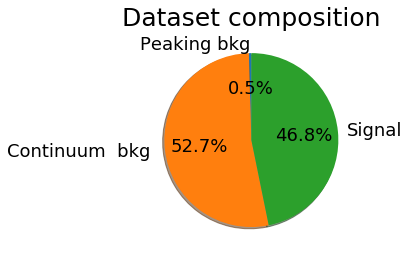

In [5]:
labels = 'Peaking bkg', 'Continuum  bkg ', 'Signal'
sizes = [Peaking_bkg.shape[0],Continuum_bkg.shape[0],Signal.shape[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 18})  
ax1.set_title('Dataset composition', fontsize=25)
plt.show()

### $5\sigma$ Cut on Reconstructed $B^0$ Mass

The reconstructed mass of the $B^0$ will differ for various reasons: 

- If an event is correctly reconstructed detector inaccuracies of all measured decay particles will add up. The estimated error for each candidate due to this can be found in the branch *B0_ErrM* and is part of our data frame. 
- If the event however is not correctly reconstructed the $B^0$ mass is not necessarily a meaningful quantity an can be far of the desired [PDG](http://pdg.lbl.gov/) value. 

By applying a generous $5\sigma$ cut we already lose a significant amount of background

In [6]:
#Masses from PDG
if cut_5_sigma == True: 
    M_B0 = [5.27955, 0.00026]
    M_K0 = [0.497611, 0.000013]
    M_etap = [0.95778, 0.00006]
    M_eta = [0.547862, 0.000017]

    #Require the B0 mass to be within 5 sigma from PDG value
    Signal = Signal[abs(Signal['B0_M'] - M_B0[0]) < 5 * Signal['B0_ErrM']]
    print("Signal : ",Signal.shape)

    Continuum_bkg = Continuum_bkg[abs(Continuum_bkg['B0_M'] - M_B0[0]) < 5 * Continuum_bkg['B0_ErrM']]
    print("Continuum : ", Continuum_bkg.shape)

    Peaking_bkg = Peaking_bkg[abs(Peaking_bkg['B0_M'] - M_B0[0]) < 5 * Peaking_bkg['B0_ErrM']]
    print("Peaking : ",Peaking_bkg.shape)

####  Comment

The decision not to use the $5\sigma$ cut was determined considering that we want to keep as much peaking background data as possible to train the DNN. The 5 sigma cut reduces the peaking background data of 41%. This is not a good trade-off compared to the 48% reduction in continuum background with this cut.

## 2. Data Preprocessing

In this chapter we:
- label our data.
- turn the label into one-hot vectors as this format is needed by Keras.
- split signal, continuum and peaking separatly into training (50%), valdation (30%) and testing (20%) and then remerge  them together to assure that the balance in the composition of the dataset is preserved.
- combine and shuffle signal, continuum and peaking for training, validation and testing, making sure that the labels are shuffled with the same permutation as the data
- standardize the data (removing mean and scaling the standard deviation to 1)
- perform a Principal Component Analysis (PCA) and use the components necessary for 99% of the variance.

In [7]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

n_classes = 3
Signal['Type'] = 2
Continuum_bkg['Type'] = 1
Peaking_bkg['Type'] = 0

# Splitting Data and Label into train, test and validation separatly for each class
X = Signal.drop('Type',axis=1)
Y = Signal['Type']
X_train_S, X_test_val_S, Y_train_S, Y_test_val_S = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
X = X_test_val_S
Y = Y_test_val_S
X_validation_S, X_test_S, Y_validation_S, Y_test_S = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_S)
del(Y_test_val_S)
X = Continuum_bkg.drop('Type',axis=1)
Y = Continuum_bkg['Type']
X_train_C, X_test_val_C, Y_train_C, Y_test_val_C = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
X = X_test_val_C
Y = Y_test_val_C
X_validation_C, X_test_C, Y_validation_C, Y_test_C = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_C)
del(Y_test_val_C)
X = Peaking_bkg.drop('Type',axis=1)
Y = Peaking_bkg['Type']
X_train_P, X_test_val_P, Y_train_P, Y_test_val_P = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
X = X_test_val_P
Y = Y_test_val_P
X_validation_P, X_test_P, Y_validation_P, Y_test_P = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_P)
del(Y_test_val_P)

# Concatenating the different classes, encoding the label as one-hot vectors and shuffling everything
X_Train=np.concatenate((X_train_S, X_train_C, X_train_P), axis=0)
X_Validation=np.concatenate((X_validation_S, X_validation_C, X_validation_P), axis=0)
X_Test=np.concatenate((X_test_S, X_test_C, X_test_P), axis=0)
Y_Train=np.concatenate((Y_train_S, Y_train_C, Y_train_P), axis=0)
Y_Validation=np.concatenate((Y_validation_S, Y_validation_C, Y_validation_P), axis=0)
Y_Test=np.concatenate((Y_test_S, Y_test_C, Y_test_P), axis=0)
Ỳ_Test_not_encoded=Y_Test #used for cut value analysis
Y_Train=to_categorical(Y_Train, num_classes=3)
Y_Validation=to_categorical(Y_Validation, num_classes=3)
Y_Test=to_categorical(Y_Test, num_classes=3)
permutation = np.random.permutation(X_Train.shape[0])
X_Train = X_Train[permutation]
Y_Train = Y_Train[permutation]
permutation = np.random.permutation(X_Validation.shape[0])
X_Validation = X_Validation[permutation]
Y_Validation = Y_Validation[permutation]
permutation = np.random.permutation(X_Test.shape[0])
X_Test = X_Test[permutation]
Y_Test = Y_Test[permutation]

print("X Train shape : ", X_Train.shape)
print("X Validation shape : ",X_Validation.shape)
print("X Test shape : ",X_Test.shape)

Using TensorFlow backend.


X Train shape :  (233545, 83)
X Validation shape :  (140127, 83)
X Test shape :  (93420, 83)


Write something about scaling and why it is important

In [8]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_Train = ss.fit_transform(X_Train)
X_Test = ss.transform(X_Test)
X_Validation = ss.transform(X_Validation)

## PCA

Principal component analysis is a method often used to reduce the dimensionality of a data set. Orthogonal transformations are performed on the data set to find the directions with the highest variance. The rotated features (principal components) are sorted in descending variance. The assumption made is, that high variance corresponds to more information and little variance can be neglected as noise.

In our example we require to keep 99% of the total variance and thus can reduce the number of components from 83 to 50

11 variables explain 50% of the variance
36 variables explain 90% of the variance
42 variables explain 95% of the variance
50 variables explain 99% of the variance 

% of dataset reduction with 99 % explained variance : 39.8


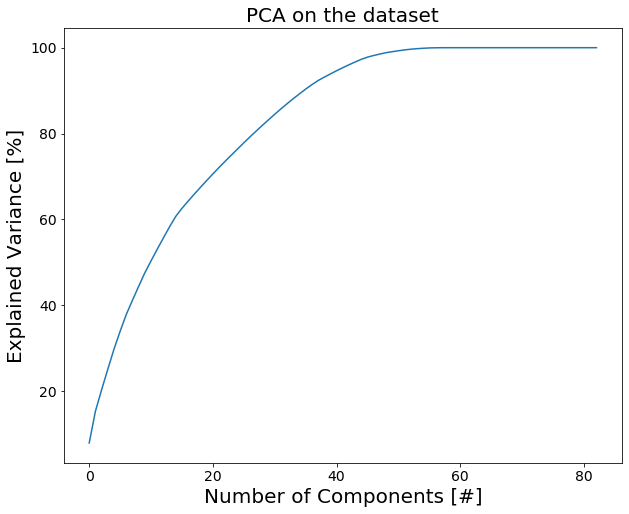

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline


pca = PCA(n_components=len(Training))
data = pca.fit_transform(X_Train)
pcTrain = pd.DataFrame(data)
pcTest = pd.DataFrame(data = pca.transform(X_Test))
pcValidation = pd.DataFrame(data = pca.transform(X_Validation))

T50, T90, T95, T99, = False, False, False, False
for i in range(len(pca.explained_variance_ratio_)) : 
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.5 and T50 ==False) : 
        print(str(i+1) + ' variables explain 50% of the variance')
        T50 = True
        n_50 = i + 1 
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.9 and T90 ==False) : 
        print(str(i+1) + ' variables explain 90% of the variance')
        T90 = True
        n_90 = i + 1
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.95 and T95 ==False) : 
        print(str(i+1) + ' variables explain 95% of the variance')
        T95 = True
        n_95 = i + 1
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.99 and T99 ==False) : 
        print(str(i+1) + ' variables explain 99% of the variance \n')
        T99 = True
        n_99 = i + 1
        
fig = plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.title('PCA on the dataset',fontsize=20)
plt.xlabel('Number of Components [#]',fontsize=20)
plt.ylabel('Explained Variance [%]',fontsize=20)
plt.tick_params(labelsize=14)
fig.set_size_inches(10, 8)
print('% of dataset reduction with 99 % explained variance :',round((X_Train.shape[1]-n_99)/X_Train.shape[1]*100,1))

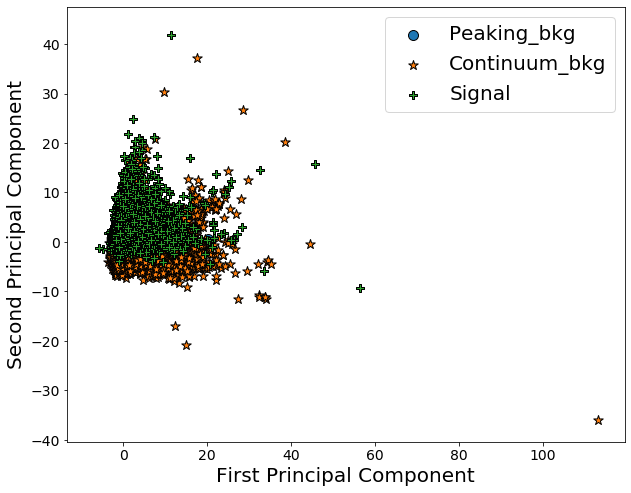

In [10]:
fig = plt.figure()
Y_Train_single_col=np.where(Y_Train==1)[1]
plt.scatter(data[Y_Train_single_col==0,0],data[Y_Train_single_col==0,1], label='Peaking_bkg',edgecolors='black',marker="o",s=100)
plt.scatter(data[Y_Train_single_col==1,0],data[Y_Train_single_col==1,1], label="Continuum_bkg", edgecolors='black', marker="*",s=100)
plt.scatter(data[Y_Train_single_col==2,0],data[Y_Train_single_col==2,1], label='Signal', edgecolors='black', marker="P",s=80)
plt.xlabel('First Principal Component',fontsize=20)
plt.ylabel('Second Principal Component',fontsize=20)
fig.set_size_inches(10, 8)
plt.tick_params(labelsize=14)
plt.legend(fontsize=20)
plt.show()

if not PCA_ON :  
    pcTrain = X_Train
    pcTest = X_Test
    pcValidation = X_Validation

In [11]:
if PCA_ON : 
    pca = PCA(n_components=n_99)
    pcTrain = pca.fit_transform(X_Train)
    pcTest = pd.DataFrame(data = pca.transform(X_Test))
    pcValidation = pd.DataFrame(data = pca.transform(X_Validation))
    print ("Input Dimension has been reduced to ", n_99)
else : 
    input_dim = 83
    print("Input Dimension has not been reduced and no PCA has been performed")

Input Dimension has not been reduced and no PCA has been performed


####  Comment
The decision not to use the PCA was determined considering that the results of the network are worse in that case, leaving all the other parameters unchanged. 
The result that gets worse is the true positive rate in the case of peaking background.

Peaking backgound accounts for 0.46 % of the total dataset. <br>
We believe that PCA embeds the dataset in the space generated by the eigenvectors that maximizes the variance explained for the rest of the dataset, but that penalizes important variables in the distinction of peaking background. <br>
In fact $\sigma \propto \sqrt{N} $ and $N_{pkg} \ll N_{tot} $, $N_{pkg}$ should be very isolated in the phase space so that its characterizing variables are kept in strong consideration. This is not the case with the analyzed dataset.

## 3. The Neural Network

explain what neural network we are using, how we have been training it

In [12]:
from keras.models import load_model
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Model1 = load_model('/home/guida/Scrivania/Best_Model.h5')
Model2 = load_model('/home/guida/Scrivania/Best_Model.h5')

print(Model1.summary())
print(Model1.evaluate(pcTest, Y_Test))
print(2*'\n')
print(Model2.summary())
print(Model2.evaluate(pcTest, Y_Test))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_148 (Dropout)        (None, 83)                0         
_________________________________________________________________
dense_662 (Dense)            (None, 50)                4200      
_________________________________________________________________
dense_663 (Dense)            (None, 100)               5100      
_________________________________________________________________
dense_664 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_665 (Dense)            (None, 50)                5050      
_______________________________________

OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-3
OMP: Info #156: KMP_AFFINITY: 4 available OS procs
OMP: Info #157: KMP_AFFINITY: Uniform topology
OMP: Info #179: KMP_AFFINITY: 1 packages x 2 cores/pkg x 2 threads/core (2 total cores)
OMP: Info #214: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to package 0 core 0 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to package 0 core 0 thread 1 
OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to package 0 core 1 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to package 0 core 1 thread 1 
OMP: Info #250: KMP_AFFINITY: pid 9174 tid 9174 thread 0 bound to OS proc set 0
OMP: Info #250: KMP_AFFINITY: pid 9174 tid 9289 thread 1 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 9174 tid 9364 thread 2 bound to OS proc set 2
OMP: Info #250: 

Talk about the performance of our model 

- Model.evaluate with Test sample
- ROCK Curve
- Confusion Matrix

## 4. XGBOOST

- Same story here as in the last chapter
- Advantages/Disadvantages compared to the DNN

To achieve the task of the classification we have tried to look at the results of the Xgboost algorithm. <br>
In fact, besides being one of the best performing algorithms to perform this type of task, [here](https://github.com/dmlc/xgboost/tree/master/demo) you can see, not only great tutorials, but also that the algorithm won several high energy physics ML competitions. <br><br>
The basic idea of the algorithm is to construct ensembles of decision trees. It work iteratively and at each step, we compute the gradient of the cost function w.r.t.the predicted value of the ensemble and add trees that move us in the direction of the gradient.

## 5. Deciding on the Cut Value of our Network

- all necessary steps and explanations for the cut value

In [13]:
Test_prob = Model1.predict(pcTest)
np.argmax(Test_prob, axis=1)

min_cut = 0.96
max_cut = 0.999
n_steps = 100
step_size = (max_cut-min_cut)/n_steps

cut_values = []
metriks1 = []
metriks2 = []
N_Ss = []
N_Bs = []

for i in range(0, n_steps) : 
    cut_value = min_cut + i*step_size
    cut_values.append(cut_value)
    N_S = 0
    N_B = 0
    for j in range(len(Test_prob)) : 
        if Test_prob[j][2] > cut_value :           #we classify it as signal
            if Y_Test[j][2] == 1 : N_S += 1        #it actually is signal
            elif Y_Test[j][2] == 0 : N_B +=1       #it isn't signal
            else : print("Unexpected!")            #This should not happen
    
    N_S = 0.00463101 * N_S
    #N_S = 1 * N_S

    N_Ss.append(N_S)
    N_Bs.append(N_B)
    metrik1 = N_S/(math.sqrt(N_B+N_S))
    metriks1.append(metrik1)
    metrik2 = N_S/math.sqrt(N_B)
    metriks2.append(metrik2)
    
cut = cut_values[np.argmax(metriks1)]

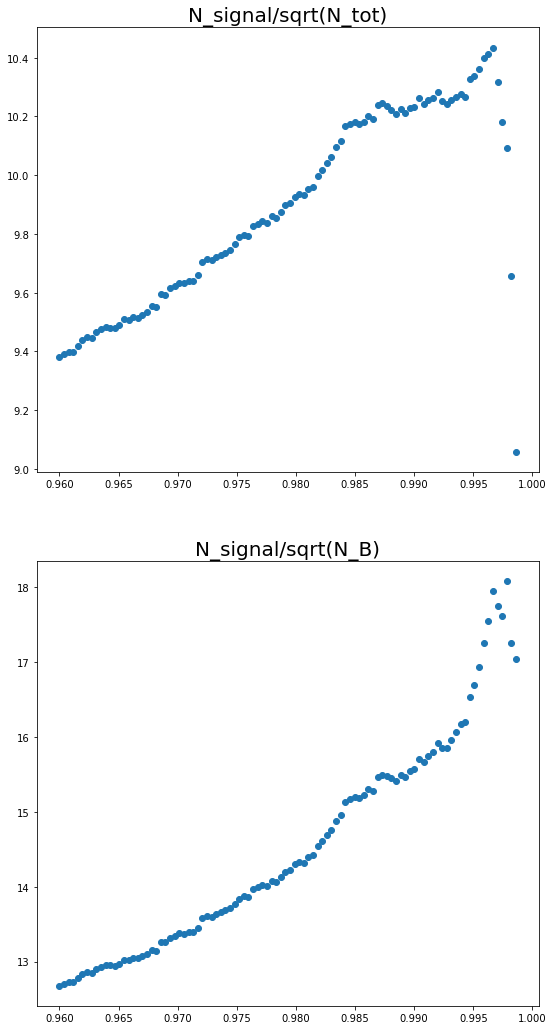

Maximum for N_signal/sqrt(N_tot) at  0.99666


In [14]:
fig, ax = plt.subplots(2,1,figsize = (9,18))
ax[0].plot(cut_values, metriks1, 'o')
ax[0].set_title("N_signal/sqrt(N_tot)",fontsize=20)
ax[1].plot(cut_values, metriks2, 'o')
ax[1].set_title("N_signal/sqrt(N_B)",fontsize=20)
plt.show()
print("Maximum for N_signal/sqrt(N_tot) at ", cut)

In [15]:
cut = cut_values[np.argmax(metriks1)]
N_TS, N_WS = 0,0

for j in range(len(Test_prob)) : 
        if Test_prob[j][2] > cut :           #we classify it as signal
            if Y_Test[j][2] == 1 : N_TS += 1        #it actually is signal
            elif Y_Test[j][2] == 0 : N_WS +=1       #it isn't signal
            else : print("Unexpected!")            #This should not happen
                
                
N_Sig = 0
for y in Y_Test : 
    if np.array_equal([0,0,1], y) : N_Sig +=1
        
eps = N_TS/N_Sig
print ("Efficiency with our cutvalue {}: ".format(cut), eps )

Efficiency with our cutvalue 0.99666:  0.812419945105215


## 6. The Data Challenge

Here we con showcase the perfect performance of our network

In [16]:
DC = pd.concat((read_root(f, 'B0', columns=Important) for f in DCFiles)).reset_index(drop=True)

In [17]:
DC = DC[Training]
pcDC = ss.transform(np.array(DC.values))

In [18]:
DC_prob = pd.DataFrame(Model1.predict(pcDC))
DC_Signal = DC[DC_prob[2] > cut]

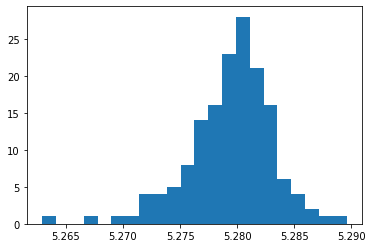

In [20]:
nbins=22
plt.hist(DC_Signal['B0_mbc'], bins=nbins)
plt.show()

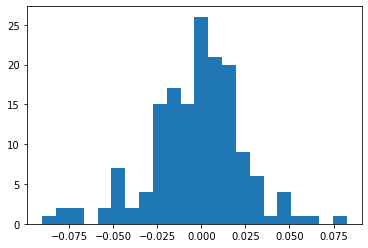

In [21]:
plt.hist(DC_Signal['B0_deltae'], bins=nbins)
plt.show()

In [22]:
from scipy.optimize import curve_fit

In [23]:
def fit_function(x, A , C, mu, sigma):
    return (A + C * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))

def flat_line(A):
    return (A)

def gaussian(x,C, mu, sigma):
    return (C * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))

In [24]:
hist, bins = np.histogram(DC_Signal['B0_mbc'], bins=nbins)
centers = (bins[:-1] + bins[1:]) / 2
popt3, pcov3 = curve_fit(fit_function,xdata=centers,ydata=hist,p0=[3,1, 5.28, 0.005])
print(popt3)
A , C, mu, sigma = popt3
dA , dC, dmu, dsigma = [np.sqrt(pcov3[j,j]) for j in range(popt3.size)]

[1.12086197e+00 2.42643067e+01 5.28008556e+00 2.63543718e-03]


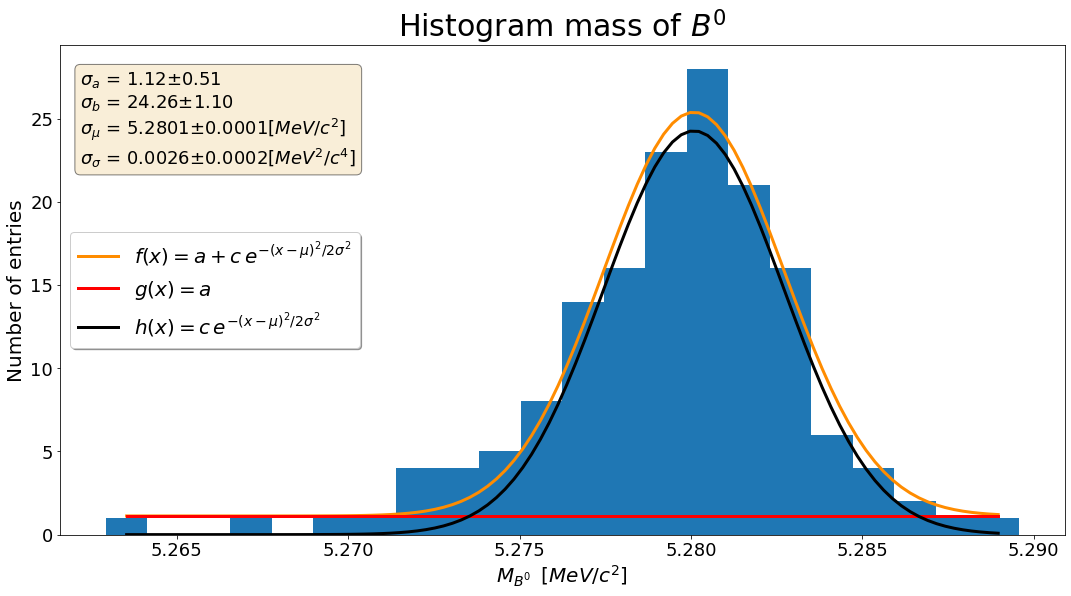

In [25]:
x = np.linspace(centers.min(), centers.max(), 100)
flat_line(*popt3[:1])
fig, ax1 = plt.subplots()
ax1.hist(DC_Signal['B0_mbc'], bins=nbins)
ax1.plot(x, fit_function(x, *popt3), color='darkorange', linewidth=3, label=r'$f(x) = a+c\,e^{-(x-\mu)^2/2\sigma^2}$')
ax1.plot(x,flat_line(*popt3[:1])*np.ones(x.shape[0]), color='red', linewidth=3, label=r'$g(x) = a$')
ax1.plot(x, gaussian(x, *popt3[1:]), color='black', linewidth=3, label=r'$h(x) = c\,e^{-(x-\mu)^2/2\sigma^2}$')
ax1.set_xlabel('$M_{B^{0}} \,\,\, [MeV/c^2]$',fontsize=20)
ax1.set_ylabel(r'Number of entries',fontsize=20)
ax1.set_title('Histogram mass of $B^{0}$',fontsize=30)
fig.set_size_inches(18, 9)
plt.tick_params(labelsize=18)
textstr = '\n'.join((
    '$\sigma_a$ = {0:0.2f}$\pm${1:0.2f}'
         .format(A, dA),
    '$\sigma_b$ = {0:0.2f}$\pm${1:0.2f}'
         .format(C, dC),
    '$\sigma_\mu$ = {0:0.4f}$\pm${1:0.4f}$[MeV/c^2]$'
         .format(mu, dmu),
     '$\sigma_\sigma$ = {0:0.4f}$\pm${1:0.4f}$[MeV^2/c^4]$'
         .format(sigma, dsigma)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.02, 0.95, textstr, transform=ax1.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)
legend = ax1.legend(loc="center left", shadow=True, fontsize=20)
plt.show()

In [26]:
import scipy.integrate as integrate
idx = np.argwhere(np.diff(np.sign(flat_line(*popt3[:1])*np.ones(x.shape[0]) - gaussian(x, *popt3[1:])))).flatten()
result =integrate.quad(lambda x: gaussian(x,C=popt3[1], mu=popt3[2], sigma=popt3[3]),x[idx][0],x[idx][1])
print("The integral under the black curve is : ", result[0])

The integral under the black curve is :  0.15815814401142578


In [27]:
bins_width=bins[1]-bins[0]
print("Number of signal :", int(result[0]/bins_width))

Number of signal : 130


## 7. Conclusion or additional comments (optional)

If you think somthing is missing feel free to add it. 
With 6 topics we can give 2 (non consecutive) topics for everybody. 
Having a little break between your two topics maybe helps a bit if something didn't go as expected. 